In [37]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
connection = {'database':'default',
              'host': 'http://clickhouse.beslan.pro:8080',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [12]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT COUNT()
FROM ldn_listings
"""

ph.execute(query, connection=connection)

b'85207\n'

In [13]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
ORDER BY
    id
LIMIT 1000
"""

df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [24]:
df.groupby(['room_type'])['price'] \
    .quantile(q=0.75) \
    .reset_index()

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [70]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM ldn_listings
WHERE
    review_scores_rating is not null
"""

df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [71]:
df.dtypes

room_type                object
price                   float32
review_scores_rating    float32
dtype: object

In [72]:
df.shape

(62122, 3)

In [84]:
df_room_mean = df.groupby('room_type', as_index=False) \
    .agg({'price': 'mean', 'review_scores_rating': 'mean'})

In [85]:
df_room_mean

,room_type,price,review_scores_rating
0,Entire home/apt,154.840469,92.301765
1,Hotel room,272.145844,85.786461
2,Private room,53.526375,93.156013
3,Shared room,78.121040,87.198845


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

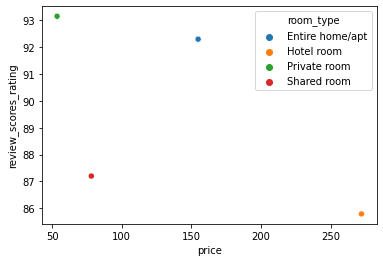

In [86]:
sns.scatterplot(data=df_room_mean, x="price", y="review_scores_rating", hue="room_type")

In [105]:
query = """
SELECT
    DISTINCT host_id,
    host_verifications
FROM ldn_listings
WHERE
    experiences_offered != 'none'
"""

df1 = ph.read_clickhouse(query, connection=connection)
df1.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [88]:
df1.dtypes

host_id               uint32
host_verifications    object
dtype: object

In [106]:
df1 = (df1
 .host_verifications
 .apply(lambda x: x.strip('[]').replace("'", '').split(', '))
 .explode()
 .value_counts())

In [107]:
df1

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [92]:
# df1.host_verifications = df1.host_verifications.apply(lambda x: x[2:-2].split("', '"))

In [109]:
string = '  xoxo love xoxo   '

In [111]:
# and right of string are removed
print(string.strip(' xoe'))

lov


In [112]:
# No characters are removed.
print(string.strip('stx'))

  xoxo love xoxo   


In [113]:
string = 'android is awesome'
print(string.strip('an'))

droid is awesome


In [10]:
query = """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT() AS experiences_count
FROM ldn_listings
WHERE
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
"""

dff = ph.read_clickhouse(query, connection=connection)
dff.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [11]:
dff = dff.pivot(index='neighbourhood_cleansed',columns='experiences_offered',values='experiences_count')

In [12]:
dff

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


In [50]:
sns.set({'figure.figsize':(12,12)})

<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

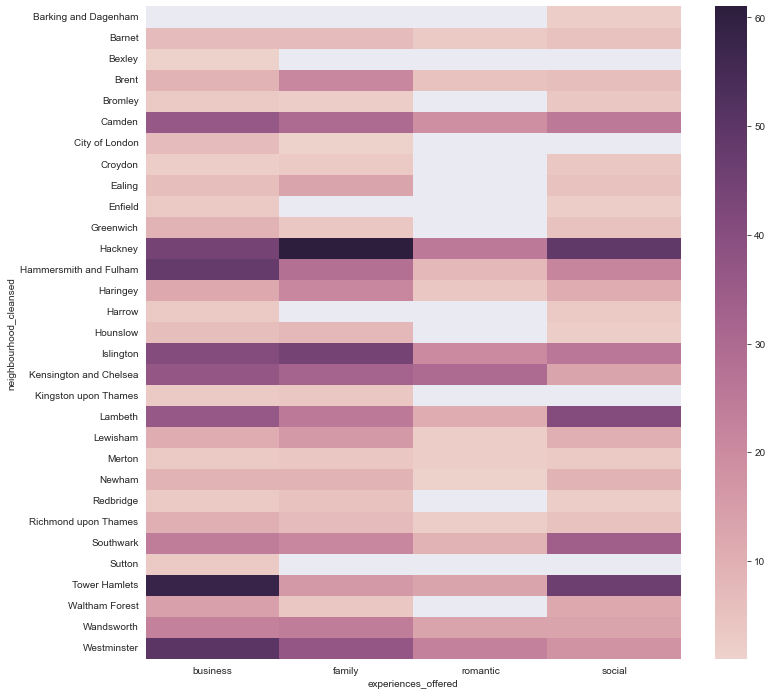

In [27]:
sns.heatmap(dff, cmap=sns.cubehelix_palette(as_cmap=True))

In [28]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
FROM ldn_listings
WHERE
    experiences_offered != 'none'
"""

dfff = ph.read_clickhouse(query, connection=connection)
dfff.head()

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [32]:
dfff.dtypes

room_type      object
price_corr    float32
dtype: object

In [41]:
dfff['price_log'] = np.log(dfff.price_corr)

In [42]:
dfff

,room_type,price_corr,price_log
0,Private room,65.0,4.174387
1,Entire home/apt,100.0,4.605170
2,Private room,150.0,5.010635
3,Private room,45.0,3.806663
4,Private room,25.0,3.218876
...,...,...,...
1543,Entire home/apt,100.0,4.605170
1544,Entire home/apt,125.0,4.828314
1545,Entire home/apt,185.0,5.220356
1546,Entire home/apt,110.0,4.700480


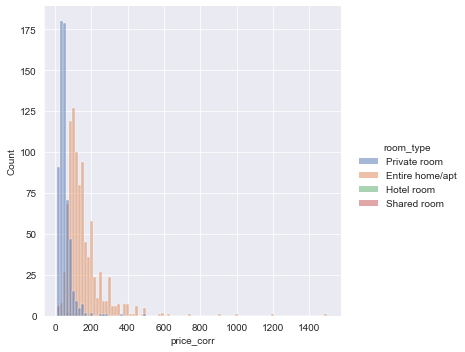

In [51]:
sns.displot(data=dfff, x='price_corr', hue='room_type')

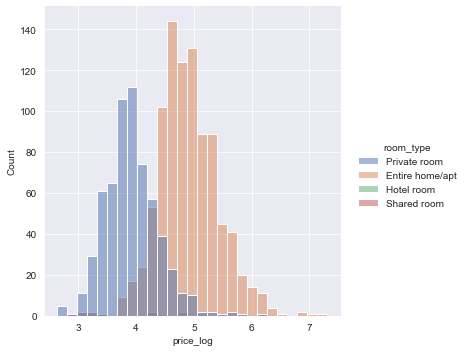

In [52]:
sns.displot(data=dfff, x='price_log', hue='room_type')

In [68]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
    first_review
FROM ldn_listings
WHERE
    first_review > '2010-01-01'
LIMIT 1000
"""

dffff = ph.read_clickhouse(query, connection=connection)
dffff.head()

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [72]:
dffff.dtypes

room_type               object
price_corr             float32
first_review    datetime64[ns]
dtype: object

In [83]:
dffff.first_review = pd.to_datetime(dffff.first_review).dt.year

In [84]:
dffff

,room_type,price_corr,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [100]:
df_price_per_year = dffff.groupby(['room_type', 'first_review'], as_index=False) \
    .agg({'price_corr': 'mean'}) \
    .rename(columns={'first_review': 'year', 'price_corr': 'avg_price'}) \
    .sort_values('year') 

In [101]:
df_price_per_year

,room_type,year,avg_price
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143
2,Entire home/apt,2012,135.467255
15,Private room,2012,53.269840
24,Shared room,2012,22.000000
3,Entire home/apt,2013,137.887634
16,Private room,2013,57.036587


<AxesSubplot:xlabel='year', ylabel='avg_price'>

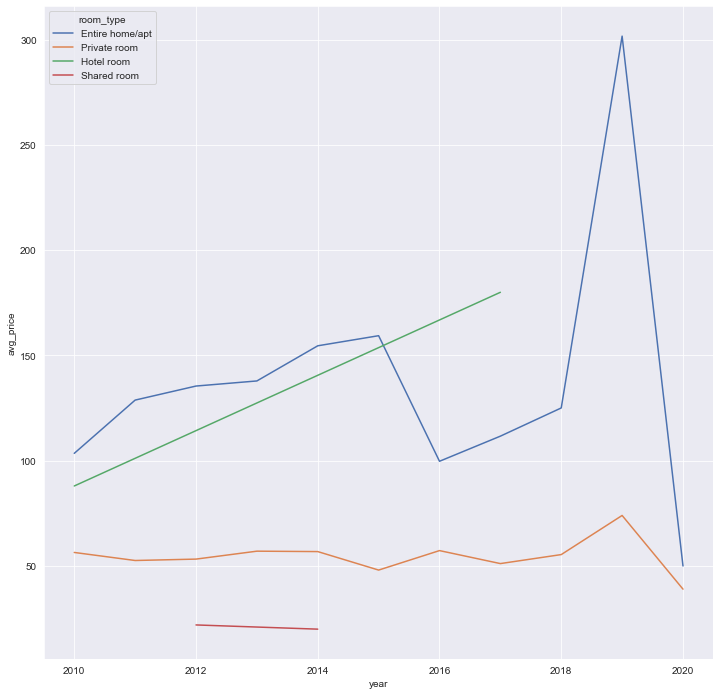

In [102]:
sns.lineplot(x='year', y='avg_price', hue='room_type', data=df_price_per_year)